In [1]:
import math
import hydra
import numpy as np
import time

from rdkit import Chem
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')

from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from typing import List, Tuple, Type

from rdkit import Chem
from rdkit.Chem import rdDistGeom
from rdkit.Chem.rdMolDescriptors import GetUSRScore, GetUSRCAT, GetUSR

from rdkit.Chem import rdDistGeom
from rdkit.Chem import AllChem

from numba import complex128, float64
from numba.experimental import jitclass
from scipy.spatial import distance

In [2]:
class USRCAT_Fitness:
    """
    A strategy class for calculating the fitness of a molecule.
    """
    def __init__(self) -> None:
        self.n_conformers = 15
        self.param = rdDistGeom.ETKDGv3()
        self.param.randomSeed=0xfb0d
        self.param.numThreads = 2
        self.target = Chem.AddHs(Chem.MolFromSmiles(Chem.CanonSmiles("O=C1NC(=O)SC1Cc4ccc(OCC3(Oc2c(c(c(O)c(c2CC3)C)C)C)C)cc4")))
        self.target_configuration = AllChem.EmbedMultipleConfs(self.target, 1, self.param)
        self.target_usrcat = GetUSRCAT(self.target)
        return None

    def __call__(self, smiles) -> None:
        """
        Updates the fitness value of a molecule.
        """
        usrcat_scores = np.zeros(self.n_conformers)
        molecular_graph = Chem.AddHs(Chem.MolFromSmiles(Chem.CanonSmiles(smiles)))
        ids = AllChem.EmbedMultipleConfs(molecular_graph, self.n_conformers, self.param)
        for conf_id in range(self.n_conformers):
            usrcat = GetUSRCAT(molecular_graph, confId=int(conf_id))
            score = GetUSRScore(usrcat, self.target_usrcat)
            usrcat_scores[conf_id] = score
        fitness = np.max(usrcat_scores)
        return fitness

In [3]:
class Zernike_Fitness:
    """
    A strategy class for calculating the fitness of a molecule.
    """
    def __init__(self) -> None:
        self.N = 20
        self.prefactor = 3/(4*math.pi)
        self.param = rdDistGeom.ETKDGv3()
        self.param.randomSeed=0xfb0d
        self.n_conformers = 15
        self.param.numThreads = 2
        self.Yljm = np.load(hydra.utils.to_absolute_path("./Yljm.npy"))
        self.Qklnu = np.load(hydra.utils.to_absolute_path("./Qklnu.npy")) 
        self.engine = Zernike_JIT(self.Qklnu, self.Yljm)

        self.target = Chem.AddHs(Chem.MolFromSmiles(Chem.CanonSmiles("O=C1NC(=O)SC1Cc4ccc(OCC3(Oc2c(c(c(O)c(c2CC3)C)C)C)C)cc4")))
        AllChem.EmbedMultipleConfs(self.target, 1, self.param)
        self.target_zernike = self.get_zernike(self.target, conf_id=0)

    def coordinate_extractor(self, molecule, confid=-1):
        x_points, y_points, z_points = [], [], []
        PDBBlock = Chem.MolToPDBBlock(molecule, confId=confid).split('\n')
        for line in PDBBlock:
            split = line.split()
            if split[0] == 'HETATM':
                x_points.append(float(split[5]))
                y_points.append(float(split[6])) 
                z_points.append(float(split[7]))
            if split[0] == 'END':
                break
        x_points, y_points, z_points = np.array(x_points), np.array(y_points), np.array(z_points)
        coordinates = np.column_stack((x_points, y_points, z_points))
        return coordinates

    def __call__(self, smiles) -> None:
        """
        Updates the fitness value of a molecule.
        """
        molecular_graph = Chem.AddHs(Chem.MolFromSmiles(Chem.CanonSmiles(smiles)))
        conf_ids = AllChem.EmbedMultipleConfs(molecular_graph, self.n_conformers, self.param)
        zernikes = [self.get_zernike(molecular_graph, conf_id) for conf_id in conf_ids]
        scores = [1. / (1 + distance.canberra(zernike, self.target_zernike)) for zernike in zernikes]
        fitness = np.max(scores)
        return fitness
    
    def get_zernike(self, molecular_graph, conf_id):
        AllChem.ComputeGasteigerCharges(molecular_graph)
        coordinates = self.coordinate_extractor(molecular_graph, conf_id)
        charges = [molecular_graph.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(molecular_graph.GetNumAtoms())]
        zernike = self.invariants(coordinates, charges, self.N)
        return zernike
        
    def invariants(self, coordinates, features, N):
        features_plus = [max(feature, 0.0)for feature in features]
        features_negative = [-1.0*min(feature, 0.0) for feature in features]
        invariants_plus = self.unsigned_invariants(coordinates, features_plus, N)
        invariants_negative  = self.unsigned_invariants(coordinates, features_negative, N)
        return invariants_plus - invariants_negative

    def unsigned_invariants(self, coordinates, features, N):
        x_points, y_points, z_points = map(list, list(zip(*coordinates)))
        lengths = [len(features), len(x_points), len(y_points), len(z_points)]
        x_points = x_points - np.mean(x_points)
        y_points = y_points - np.mean(y_points)
        z_points = z_points - np.mean(z_points)
        features = np.array(features)
        geometric_moments = self.engine.geometric_moments(features, x_points, y_points, z_points, N)
        invariants = self.engine.zernike_invariants(geometric_moments, N)
        return np.real(invariants)
        
spec = [('prefactor', float64), ('Qklnu', complex128[:,:,:]), ('Yljm', complex128[:,:,:])]
@jitclass(spec)
class Zernike_JIT:
    def __init__(self, Qklnu, Yljm):
        self.prefactor = 3/(4*math.pi)
        self.Qklnu = Qklnu
        self.Yljm = Yljm
        
    def geometric_moments(self, features, x_points, y_points, z_points, N):
        geometric_moments = np.zeros((N + 1, N + 1, N + 1))
        for i in range(N + 1):
            for j in range(N + 1): 
                for k in range(N+1):
                    if N >= (i+j+k):
                        for f, x, y, z in zip(features, x_points, y_points, z_points):
                            geometric_moments[i, j, k] += f*(np.power(x, i) * np.power(y, j) * np.power(z, k))
        return geometric_moments
    
    def choose(self, n, k):
        if 0 <= k <= n:
            ntok = 1.0
            ktok = 1.0
            for t in range(1, min(k, n - k) + 1):
                ntok *= n
                ktok *= t
                n -= 1.0
            return ntok // ktok
        else:
            return 0.0
    
    def zernike_invariants(self, geometric_moments, N):
        invariants = []
        V = np.zeros((N + 1, N + 1, N + 1), dtype=complex128)
        W = np.zeros((N + 1, N + 1, N + 1), dtype=complex128)
        X = np.zeros((N + 1, N + 1, N + 1), dtype=complex128)
        Y = np.zeros((N + 1, N + 1, N + 1), dtype=complex128)
        Z = np.zeros((N + 1, N + 1, N + 1), dtype=complex128) 
        
        for a in range(N + 1):
            for b in range(N + 1): 
                for c in range(N + 1):
                    if N >= 2*a+b+c:
                    	for alpha in range(a+c+1):
                            V[a,b,c] += np.power(1j, alpha)*self.choose(a+c, alpha)*geometric_moments[2*a+c-alpha, alpha, b]
                    	
        for a in range(N + 1):
            for b in range(N + 1): 
                for c in range(N + 1):
                    if N >= 2*a+b+c:
                    	for alpha in range(a+1):
                    		W[a,b,c] += np.power(-1.0, alpha)*np.power(2.0, a-alpha)*self.choose(a, alpha)*V[a-alpha, b, c+2*alpha]
                                
        for a in range(N + 1):
            for b in range(N + 1): 
                for c in range(N + 1):
                    if N >= 2*a+b+c:
                    	for alpha in range(a+1):
                    		X[a,b,c] += self.choose(a, alpha)*W[a-alpha, b+2*alpha, c]
        
        for l in range(N + 1):
            for m in range(l + 1): 
                for nu in range(math.floor((N-l)/2)+1):
                        for j in range(math.floor((l-m)/2)+1):
                            Y[l,nu,m] += self.Yljm[l,j,m]*X[nu+j,l-m-2*j,m]
       
        for n in range(N + 1):
            for l in range(n + 1): 
                for m in range(l+1):
                    if (n-l)%2 == 0:
                        k = int((n-l)/2)
                        for nu in range(k+1):
                            Z[n,l,m] += self.prefactor*self.Qklnu[k,l,nu]*np.conj(Y[l,nu,m])

        for n in range(N+1):
            for l in range(n+1):
                if (n-l)%2 == 0:
                    sigma_vector = []
                    for m in range(-l,l+1):
                        if m < 0:
                            sigma_vector.append(((-1)**abs(m))*np.conj(Z[n,l,abs(m)])) 
                        else:             
                            sigma_vector.append(Z[n,l,m])
                    norm = np.sqrt(np.sum(np.array([np.conj(c)*c for c in sigma_vector])))
                    invariants.append(norm)
        invariants = np.array(invariants)           
        return invariants      

In [4]:
u = USRCAT_Fitness()

In [5]:
z = Zernike_Fitness()

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
import pandas as pd
import numpy as np

# Load CSV file into a pandas DataFrame
file_path = './molecules.csv'  # Replace with the actual file path
df = pd.read_csv(file_path)

# Ensure the DataFrame is sorted by fitness within each niche
df_sorted = df.sort_values(by=['niche_index', 'fitness'])

# Randomly select one molecule with the lowest fitness from each niche
random_per_niche = df_sorted.groupby('niche_index').apply(lambda x: x.sample(1, random_state=42))  # Adjust random_state as needed
# Select the lowest and highest scoring molecules within each niche
lowest_per_niche = df.groupby('niche_index')['fitness'].idxmin()
highest_per_niche = df.groupby('niche_index')['fitness'].idxmax()

lowest_fitness = df.loc[lowest_per_niche]
highest_fitness = df.loc[highest_per_niche]

# Reset index to ensure correct indexing after grouping
random_per_niche.reset_index(drop=True, inplace=True)
lowest_fitness.reset_index(drop=True, inplace=True)
highest_fitness.reset_index(drop=True, inplace=True)

In [8]:
# Add 'u' and 'z' columns to the DataFrame
random_per_niche['u'] = random_per_niche['smiles'].apply(u)
lowest_fitness['u'] = lowest_fitness['smiles'].apply(u)
highest_fitness['u'] = highest_fitness['smiles'].apply(u)

In [9]:
# Add 'u' and 'z' columns to the DataFrame
random_per_niche['z'] = random_per_niche['smiles'].apply(z)
lowest_fitness['z'] = lowest_fitness['smiles'].apply(z)
highest_fitness['z'] = highest_fitness['smiles'].apply(z)

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
sns.set_theme(style="white")
sns.set_context("talk", font_scale=0.9)

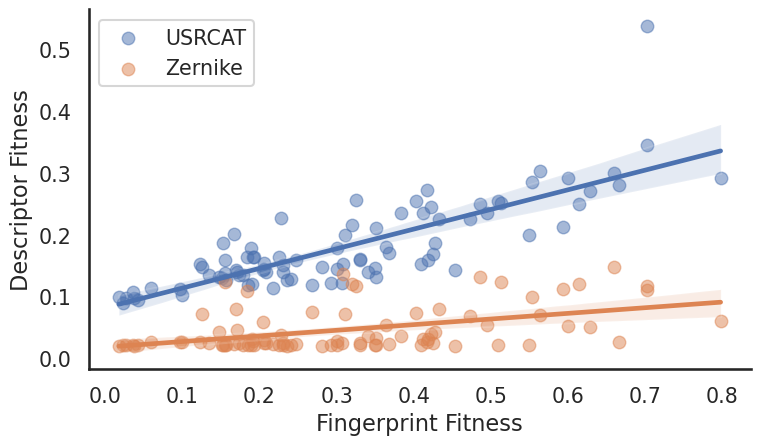

In [12]:
new_rows = []

for index, row in random_per_niche.iterrows():
    # Create a new row for 'u'
    new_row_u = row.copy()
    new_row_u['descriptor_value'] = row['u']
    new_row_u['Descriptor'] = 'USRCAT'
    new_rows.append(new_row_u)

    # Create a new row for 'z'
    new_row_z = row.copy()
    new_row_z['descriptor_value'] = row['z']
    new_row_z['Descriptor'] = 'Zernike'
    new_rows.append(new_row_z)

# Create a new DataFrame with the duplicated rows
expanded_df = pd.DataFrame(new_rows)
expanded_df.to_csv("expanded_df")
# Create lmplot
lm = sns.lmplot(x='fitness', y='descriptor_value', hue='Descriptor', data=expanded_df, scatter_kws={"alpha": 0.5},  legend=False, aspect=1.7)
lm.fig.subplots_adjust(top=0.9, right=0.9)  # Adjust top and right margin
lm.ax.legend(loc='upper left', bbox_to_anchor=(0, 1))

# Set custom axis labels
plt.xlabel('Fingerprint Fitness')
plt.ylabel('Descriptor Fitness')

plt.savefig('lmplot_figure.pdf', bbox_inches='tight', dpi=300)

plt.show()

In [13]:
random_per_niche

,acquisition_value,descriptor,fitness,niche_index,pedigree,predicted_fitness,predicted_uncertainty,smiles,u,z
0,0.402950,"[0.6832065186133336, 0.5998500000000002, 0.606...",0.383178,3,"('mutation', '[*:1]~[D1]>>[*:1]', 'CC(O)=CC(=C...",0.402950,0.000325,O=C1NC(=O)C(Cc2ccc(OC=C(C=CO)OBr)cc2)S1,0.234887,0.035822
1,0.044570,"[0.41400996409333324, 0.3430333333333333, 0.15...",0.059701,4,"('crossover', 'CN1CCN(Cc2ccc(CN3CCN(N4CCN(OCl)...",0.044570,0.000431,CC(C)(C)CCN1CCN(N2CCN(OCl)CC2)CC1,0.113938,0.026111
2,0.315597,"[0.6671727541599999, 0.23960000000000004, 0.59...",0.319672,5,"('crossover', 'Cc1c(C)c2c(c(C)c1O)CC(C)(CC1SC(...",0.315597,0.001170,COCOc1ccc(N2CCN(NCCC3SC(=O)NC3=O)CC2)cc1,0.215331,0.121348
3,0.185974,"[0.8265408954533331, 0.9329500000000007, 0.197...",0.192000,6,"('crossover', 'Cc1c(C)c2c(c(C)c1O)CC(C)(COc1cc...",0.185974,0.000135,CC(COc1ccc(Cc2ccc(COBr)cc2)cc1)OBr,0.164197,0.029173
4,0.248808,"[0.09683683197333333, 0.32007, 0.2737857142857...",0.235294,7,"('crossover', 'COC1(C(=O)NCC2SC(=O)NC2=O)CCc2c...",0.248808,0.000762,Cc1ccc(OC2SCNC2=O)cc1,0.127071,0.020498
...,...,...,...,...,...,...,...,...,...,...
82,0.271740,"[0.6709267091333334, 0.6736433333333339, 0.135...",0.281250,143,"('mutation', '[*:1]~[D3](~[*;!H0:2])~[*:3]>>[*...",0.271740,0.000381,Cc1c(C)c2c(c(C)c1CC1C=CN(C)C1)CC(C)(CN1C=CN(C)...,0.148487,0.020950
83,0.188867,"[0.5141229206666666, 0.26120000000000015, 0.30...",0.190840,145,"('crossover', 'CCOc1ccc(CN2CCN(N3CCN(O)CC3)CC2...",0.188867,0.000413,CCc1ccc(OCCN2CCN(N3CCN(O)CC3)CC2)cc1,0.120063,0.031783
84,0.518393,"[0.8204202855866665, 0.3654433333333333, 0.814...",0.513761,146,"('mutation', '[*;!H0;!R:1]>>[*:1]-F', 'COCC1(C...",0.518393,0.000148,Cc1c(C)c2c(c(C)c1O)CCC(COCF)(C(=O)NCC1SC(=O)NC...,0.251335,0.124067
85,0.052245,"[0.5925623652000002, 0.33075000000000004, 0.40...",0.026786,147,"('crossover', 'O=C1SC(OCC(OBr)OCC(OBr)OBr)C1=O...",0.052245,0.000430,OC(OBr)OCC(OBr)OBr,0.097688,0.021112


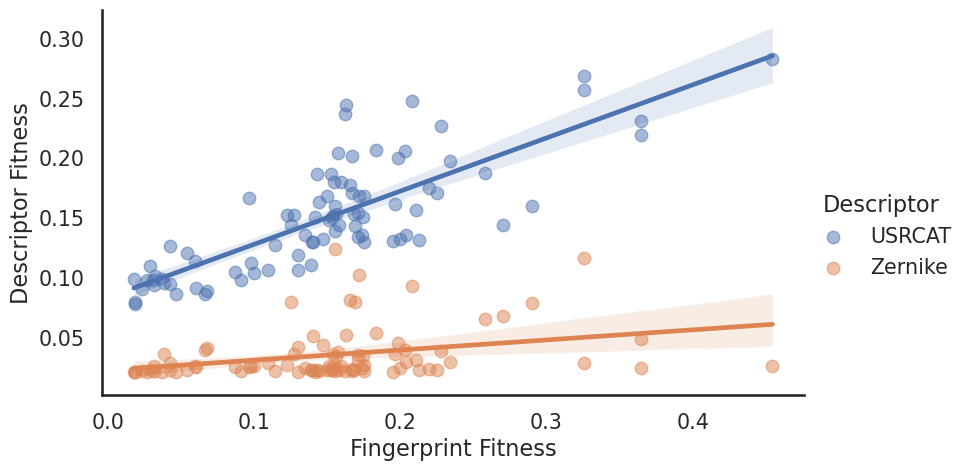

In [14]:
new_rows = []

for index, row in lowest_fitness.iterrows():
    # Create a new row for 'u'
    new_row_u = row.copy()
    new_row_u['descriptor_value'] = row['u']
    new_row_u['Descriptor'] = 'USRCAT'
    new_rows.append(new_row_u)

    # Create a new row for 'z'
    new_row_z = row.copy()
    new_row_z['descriptor_value'] = row['z']
    new_row_z['Descriptor'] = 'Zernike'
    new_rows.append(new_row_z)

# Create a new DataFrame with the duplicated rows
expanded_df = pd.DataFrame(new_rows)

# Create lmplot
sns.lmplot(x='fitness', y='descriptor_value', hue='Descriptor', data=expanded_df, scatter_kws={"alpha": 0.5}, aspect=1.7)

# Set custom axis labels
plt.xlabel('Fingerprint Fitness')
plt.ylabel('Descriptor Fitness')

plt.show()

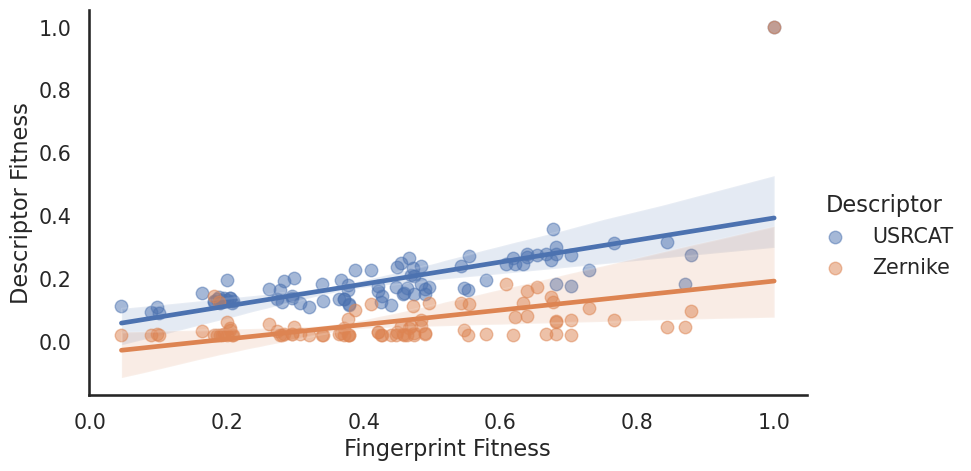

In [15]:
new_rows = []

for index, row in highest_fitness.iterrows():
    # Create a new row for 'u'
    new_row_u = row.copy()
    new_row_u['descriptor_value'] = row['u']
    new_row_u['Descriptor'] = 'USRCAT'
    new_rows.append(new_row_u)

    # Create a new row for 'z'
    new_row_z = row.copy()
    new_row_z['descriptor_value'] = row['z']
    new_row_z['Descriptor'] = 'Zernike'
    new_rows.append(new_row_z)

# Create a new DataFrame with the duplicated rows
expanded_df = pd.DataFrame(new_rows)

# Create lmplot
sns.lmplot(x='fitness', y='descriptor_value', hue='Descriptor', data=expanded_df, scatter_kws={"alpha": 0.5}, aspect=1.7)

# Set custom axis labels
plt.xlabel('Fingerprint Fitness')
plt.ylabel('Descriptor Fitness')

plt.show()

In [129]:
random_per_niche['fitness'].corr(random_per_niche['u'])

0.8127722482822052

In [130]:
random_per_niche['fitness'].corr(random_per_niche['u'], method='spearman')

0.7918494926518947

In [131]:
random_per_niche['fitness'].corr(random_per_niche['u'], method='kendall')

0.6079401203892898

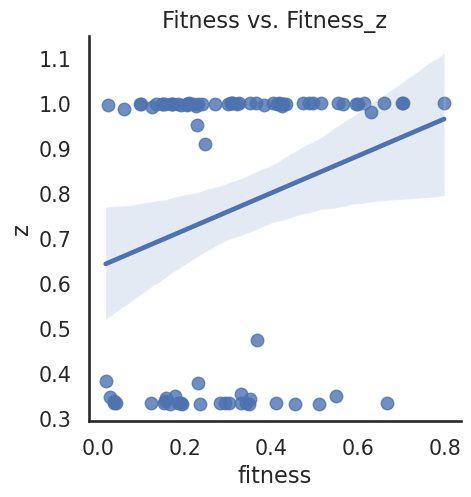

In [37]:
random_per_niche['z'] = random_per_niche['smiles'].apply(z)

# Create lmplot comparing 'fitness' to 'z'
sns.lmplot(x='fitness', y='z', data=random_per_niche)
plt.title('Fitness vs. Fitness_z')
plt.show()


In [132]:
random_per_niche['fitness'].corr(random_per_niche['z'])

0.4637668477812432

In [133]:
random_per_niche['fitness'].corr(random_per_niche['z'], method='spearman')

0.4381717857985713

In [134]:
random_per_niche['fitness'].corr(random_per_niche['z'], method='kendall')

0.3026333404928214